# 東京エレクトロン株価（日足）

In [18]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '8035.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-13 00:00:00+09:00,34677.988665,35312.100457,33934.888908,34321.300781,4193300,0.0,0.0
2024-05-14 00:00:00+09:00,34370.841689,34707.713588,33964.613811,34271.761719,2421800,0.0,0.0
2024-05-15 00:00:00+09:00,34856.331112,35470.626885,34737.435156,34905.871094,2933300,0.0,0.0
2024-05-16 00:00:00+09:00,36263.266270,36649.678124,35728.234473,36481.242188,4076200,0.0,0.0
2024-05-17 00:00:00+09:00,35817.408919,36104.740830,35470.629026,35757.960938,3125600,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-05 00:00:00+09:00,22870.000000,23285.000000,22640.000000,22930.000000,2999200,0.0,0.0
2024-11-06 00:00:00+09:00,23200.000000,23730.000000,23130.000000,23460.000000,4002800,0.0,0.0
2024-11-07 00:00:00+09:00,23605.000000,23670.000000,22595.000000,23055.000000,3888700,0.0,0.0


## パラボリック SAR

In [19]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

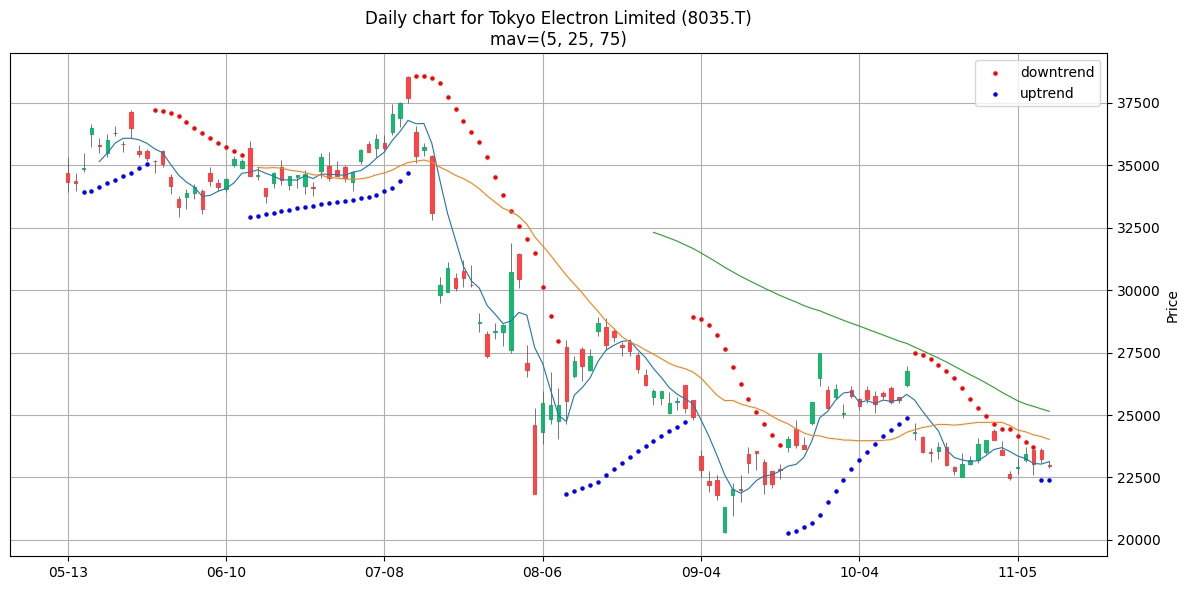

In [20]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='yahoo',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_8035.png')
plt.show()

In [21]:
df.tail(2)['Close']

Date
2024-11-08 00:00:00+09:00    23250.0
2024-11-11 00:00:00+09:00    22980.0
Name: Close, dtype: float64

In [22]:
df.tail(2)['Close'].diff()

Date
2024-11-08 00:00:00+09:00      NaN
2024-11-11 00:00:00+09:00   -270.0
Name: Close, dtype: float64

In [24]:
df = ticker.history(period='1d', interval='1m')
dt_noon = pd.to_datetime('%s 12:00:00+09:00' % str(df.index[0].date()))
df[df.index > dt_noon]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-11-11 12:30:00+09:00,23005.0,23050.0,23000.0,23035.0,1264800,0.0,0.0
2024-11-11 12:31:00+09:00,23035.0,23035.0,23035.0,23035.0,200,0.0,0.0
2024-11-11 12:32:00+09:00,23035.0,23055.0,23035.0,23045.0,13700,0.0,0.0
2024-11-11 12:33:00+09:00,23045.0,23045.0,23045.0,23045.0,100,0.0,0.0
2024-11-11 12:34:00+09:00,23040.0,23075.0,23040.0,23070.0,18800,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-11 14:55:00+09:00,23260.0,23265.0,23240.0,23245.0,11000,0.0,0.0
2024-11-11 14:56:00+09:00,23245.0,23250.0,23235.0,23235.0,2200,0.0,0.0
2024-11-11 14:57:00+09:00,23235.0,23235.0,23220.0,23225.0,5600,0.0,0.0
